<a href="https://colab.research.google.com/github/darthfelipe21/LangGraph/blob/main/LangGraphMultiAgentFramework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Another agent!


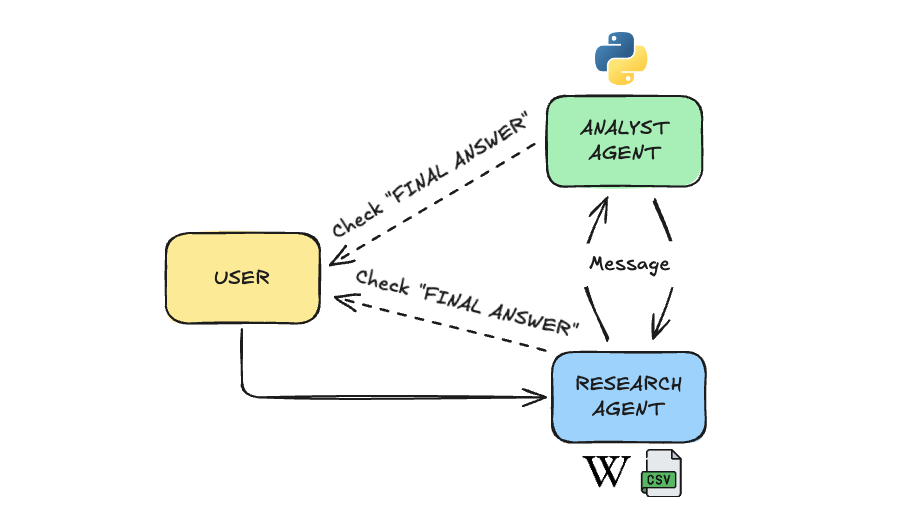

In [ ]:
!pip install --quiet wikipedia==1.4.0 langchain-core==0.3.69 langgraph==0.5.3 langchain-openai==0.3.28 langchain-experimental==0.3.4 langgraph-swarm==0.0.13

In [ ]:
from typing import Annotated
import wikipedia
from langchain_core.tools import tool
import pandas as pd
import os

@tool
def wikipedia_tool(
    query: Annotated[str, "The Wikipedia search to execute to find key summary information."],
):
    """Use this to search Wikipedia for factual information."""
    try:
        # Step 1: Search using query
        results = wikipedia.search(query)

        if not results:
            return "No results found on Wikipedia."

        # Step 2: Retrieve page title
        title = results[0]

        # Step 3: Fetch summary
        summary = wikipedia.summary(title, sentences=8, auto_suggest=False, redirect=True)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\nWikipedia summary: {summary}"

@tool
def stock_data_tool(
    company_ticker: Annotated[str, "The ticker symbol of the company to retrieve their stock performance data."],
    num_days: Annotated[int, "The number of business days of stock data required to respond to the user query."]
) -> str:
    """
    Use this to look-up stock performance data for companies to retrieve a table from a CSV. You may need to convert company names into ticker symbols to call this function, e.g, Apple Inc. -> AAPL, and you may need to convert weeks, months, and years, into days.
    """

    # Load the CSV for the company requested
    file_path = f"data/{company_ticker}.csv"

    if os.path.exists(file_path) is False:
        return f"Sorry, but data for company {company_ticker} is not available. Please try Apple, Amazon, Meta, Microsoft, Netflix, or Tesla."

    stock_df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

    # Ensure the index is in date format
    stock_df.index = stock_df.index.date

    # Maximum num_days supported by the dataset
    max_num_days = (stock_df.index.max() - stock_df.index.min()).days

    if num_days > max_num_days:
        return "Sorry, but this time period exceeds the data available. Please reduce it to continue."

    # Get the most recent date in the DataFrame
    final_date = stock_df.index.max()

    # Filter the DataFrame to get the last num_days of stock data
    filtered_df = stock_df[stock_df.index > (final_date - pd.Timedelta(days=num_days))]

    return f"Successfully executed the stock performance data retrieval tool to retrieve the last *{num_days} days* of data for company **{company_ticker}**:\n\n{filtered_df.to_markdown()}"

from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. The chart should be displayed using `plt.show()`."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed the Python REPL tool.\n\nPython code executed:\n\`\`\`python\n{code}\n\`\`\`\n\nCode output:\n\`\`\`\n{result}\`\`\`"

### 🐝 Starting the swarm
Let's upgrade our single-agent system to multi-agent system! We'll start with two agents arranged as a **swarm**: a researcher, that can trigger the Wikipedia tool (`wikipedia_tool()`), and a data analyst, that can trigger the stock performance data and Python REPL tools (`stock_data_tool()` and `python_repl_tool()`, respectively).

To get our swarm multi-agent started, we'll create a handoff tool for each agent, so it can choose to use its original toolset, or handoff to the other agent.

These tools, like the other tools we've created, need to have clear descriptions so the agent can determine the most appropriate action.

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph_swarm import create_handoff_tool

llm = ChatOpenAI(model="gpt-4o-mini")

# Create a handoff tool for analyst -> researcher
transfer_to_researcher = create_handoff_tool(
    agent_name="researcher",
    description="Transfer user to the analyst assistant, who can create visualizations of provided data.",
)

# Create a handoff tool for researcher -> analyst
transfer_to_analyst = create_handoff_tool(
    agent_name="analyst",
    description="Transfer user to the researcher assistant, who can retrieve Wikipedia summaries or load stock performance data from CSV files.",
)

These handoff tools can then be added to the tool list like any other tool! To create both of these agents, we'll use LangGraph's `create_react_agent()` function. You can create these agents using the low-level LangGraph node/edge syntax you used earlier, but as we move to the multi-agent case, this code can get quite long.

In [ ]:
from langgraph.prebuilt import create_react_agent

# Create a researcher agent with access to two tools + the handoff tool
research_agent = create_react_agent(
    llm,
    tools=[wikipedia_tool, stock_data_tool, transfer_to_analyst],
    prompt="You provide summaries from Wikipedia, and can load raw, numerical stock performance data from CSV files.",
    name="researcher"
)

# Create a analyst agent with access to one tool + the handoff tool
analyst_agent = create_react_agent(
    llm,
    [python_repl_tool, transfer_to_researcher],
    prompt="You generate plots of stock performance data provided by another assistant.",
    name="analyst"
)

Now to bring the agents together! We'll create a short-term memory so the graph can track which agents have been called, and then create the swarm using the handy `create_swarm()` function, setting the default agent to `"researcher"`.

The LangGraph `InMemorySaver` class is equivalent to the `State` implementation you wrote for the single-agent case. For multi-agents, having a memory is crucial to enable successful collaboration between agents.

The memory is past to the `checkpointer` argument of `.compile()`, and a config is required that has been provided for you.

In [ ]:
from langgraph_swarm import create_swarm
from langgraph.checkpoint.memory import InMemorySaver

config = {"configurable": {"thread_id": "1", "user_id": "1"}}
checkpointer = InMemorySaver()

# Create the swarm multi-agent graph and compile it
swarm = create_swarm(
    agents=[research_agent, analyst_agent],
    default_active_agent="researcher"
).compile(checkpointer=checkpointer)

Run the two code blocks below to visualize your multi-agent network graph and play around with your system! 🚀

Try re-running the same inputs as before to spot the difference!

- Tell me about Apple Inc.
- AAPL stock price.
- My name is <Insert your name>.
- Plot an Open price time-series of AAPL.

In [ ]:
# Visualize your graph
swarm

### 🧪 Testing user inputs
Time to call the supervisor agent to test out how it performs!

- Who is Apple's CEO?
- Has Tesla's share price increased over the last month?
- Plot a chart of the Google's share price over the last month.

In [ ]:
from course_helper_functions import pretty_print_messages

for chunk in swarm.stream(
    {"messages": [{"role": "user", "content": "Who is Apple's CEO?"}]}, config
):
    pretty_print_messages(chunk)